In [ ]:
!git clone https://github.com/fastforwardlabs/extractive-summarization-with-sentencebert

Cloning into 'extractive-summarization-with-sentencebert'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.


In [ ]:
!pip install -q transformers datasets rouge-score

     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 451 kB 63.4 MB/s 
     |████████████████████████████████| 182 kB 53.2 MB/s 
     |████████████████████████████████| 7.6 MB 28.5 MB/s 
     |████████████████████████████████| 212 kB 56.7 MB/s 
     |████████████████████████████████| 115 kB 56.5 MB/s 
     |████████████████████████████████| 127 kB 48.4 MB/s 


In [ ]:
#install spacy large language model. (Colab needs to be restarted/)
!python -m spacy download en_core_web_lg

2022-11-30 05:19:58.339747: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
  
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_lg')

In [ ]:
cnn_ds = tfds.as_numpy(tfds.load(
    'cnn_dailymail',
    split='test',
    batch_size=-1
))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/287113 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cnn_dailymail/3.3.0.incompleteSQ565E/cnn_dailymail-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/13368 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cnn_dailymail/3.3.0.incompleteSQ565E/cnn_dailymail-validation.tfrecord*...:   …

Generating test examples...:   0%|          | 0/11490 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cnn_dailymail/3.3.0.incompleteSQ565E/cnn_dailymail-test.tfrecord*...:   0%|   …

Dataset cnn_dailymail downloaded and prepared to ~/tensorflow_datasets/cnn_dailymail/3.3.0. Subsequent calls will reuse this data.


In [ ]:
cnn_df = pd.DataFrame(cnn_ds)
cnn_df.highlights = cnn_df.highlights.apply(lambda x: x.decode('utf-8')) 
cnn_df["summary"] = cnn_df.highlights.apply(lambda x: "".join(x.split("\n")) ) 
cnn_df.article = cnn_df.article.apply(lambda x: x.decode('utf-8')) 
cnn_df["art_sents"] = cnn_df.article.apply(lambda x: len([x for x in nlp(x).sents])) 
cnn_df

,article,highlights,publisher,summary,art_sents
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,b'dm',Experts question if packed out planes are put...,16
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,b'dm',Drunk teenage boy climbed into lion enclosure ...,16
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,b'dm',Nottingham Forest are close to extending Dougi...,6
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,b'dm',Fiorentina goalkeeper Neto has been linked wit...,15
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",b'dm',"Tell-all interview with the reality TV star, 6...",34
...,...,...,...,...,...
11485,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...,b'dm',Oxford scientists say a Mercury-like body stru...,32
11486,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...,b'dm',Man accused of helping former lover kill woman...,40
11487,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...,b'dm',Marianne Power tried the tuning fork facial at...,92
11488,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...,b'dm',Brooklyn Nets beat the Portland Trail Blazers ...,9


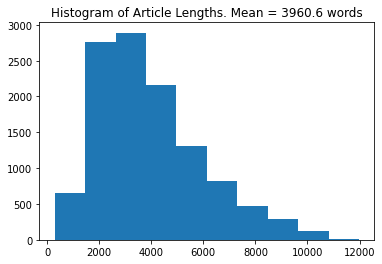

In [ ]:
art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(art_lengths);
plt.title("Histogram of Article Lengths. Mean = " + str(round(sum(art_lengths)/ len(art_lengths),1)) + " words" );

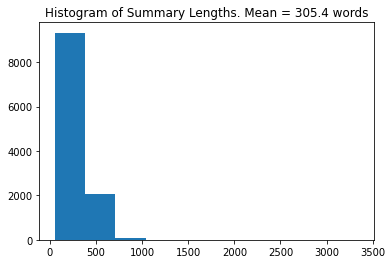

In [ ]:
sum_lengths = [ len(x) for x in cnn_df.summary] 
plt.hist(sum_lengths);
plt.title("Histogram of Summary Lengths. Mean = " + str(round(sum(sum_lengths)/ len(sum_lengths),1)) + " words" );

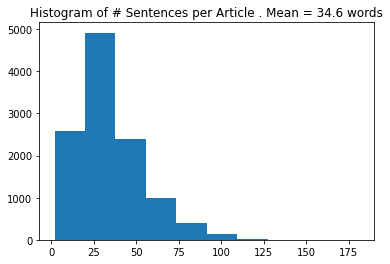

In [ ]:
# art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(cnn_df.art_sents);
plt.title("Histogram of # Sentences per Article . Mean = " + str(round(sum(cnn_df.art_sents)/ len(cnn_df.art_sents),1)) + " words" );

In [ ]:
import os

In [ ]:
test_df =  pd.DataFrame(tfds.as_numpy(tfds.load( 'cnn_dailymail', split='test', batch_size=-1)))
train_df = pd.DataFrame(tfds.as_numpy(tfds.load( 'cnn_dailymail', split='train', batch_size=-1)))

test_df.highlights = test_df.highlights.apply(lambda x: x.decode('utf-8')) 
train_df.highlights = train_df.highlights.apply(lambda x: x.decode('utf-8')) 

test_df.article = test_df.article.apply(lambda x: x.decode('utf-8')) 
train_df.article = train_df.article.apply(lambda x: x.decode('utf-8')) 

test_df.shape, train_df.shape

((11490, 3), (287113, 3))

In [ ]:
os.makedirs("data/", exist_ok=True) 
os.makedirs("data/test", exist_ok=True) 
os.makedirs("data/train", exist_ok=True) 

test_df.to_json("data/test/test.json")
train_df.to_json("data/train/train.json")

In [ ]:
def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df.article[i], "highlight": df.highlights[i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = [] 
  i = 0
  min_sent_length = 14
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    highlight = doc_dict[k]["highlight"] 
    sents = nlp(article).sents
    doc_sent_ids = [] 
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) }) 
        raw_sents.append(str(sent))
        i += 1  
         
  return doc_dict, sents_list

test_doc_dict, test_sents_list = get_dicts(test_df)
train_doc_dict, train_sents_list = get_dicts(train_df)

  0%|          | 0/11490 [00:00<?, ?it/s]

  0%|          | 0/287113 [00:00<?, ?it/s]

In [ ]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (sentence, doc, label_score)
  
def sub_sample(sents_batch, doc_dict, neg_multiplier=2):
  # get labels 
  vals = [get_label(x, doc_dict)  for x in sents_batch] 

  # construct arrays of sentences, corresponding documents and labels  
  sents, docs, y = [], [], [] 
  for row in vals:
    sents.append(row[0])
    docs.append(row[1])
    y.append(row[2])
   

  # get balanced number of positive and negative
  sub_df = pd.DataFrame.from_dict({"sents":sents, "docs":docs, "y":y}) 
  pos_df = sub_df[sub_df.y == 1]
  neg_df = sub_df[sub_df.y == 0]

  print("Negative sample size:", len(neg_df))
  print("Positive sample size:", len(pos_df))

  sub_neg_df = neg_df.sample(len(pos_df)*neg_multiplier) 
  balanced_df = pos_df.append(sub_neg_df)
  
  return balanced_df

In [ ]:
train_bdf = sub_sample(train_sents_list, train_doc_dict)
test_bdf = sub_sample(test_sents_list, test_doc_dict)

train_bdf.to_json("data/train_bdf.json")
test_bdf.to_json("data/test_bdf.json")

!gsutil cp -r data $sum_dir

In [ ]:
#define a directory to save data 
sum_dir = "drive/MyDrive/extractivesummarization/"
!gsutil cp -r data $sum_dir